In [1]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
from collections import Counter
from data_science_toolkit.data_visualization import get_fig_ax, visualize_class_distribution, top_n_tokens_plot_from_counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize 
# Stealing stuff... http://brandonrose.org/clustering
from nltk.stem.snowball import SnowballStemmer
import nltk, re
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora, models, similarities 
from data_science_toolkit.association_rules import apriori_with_df
from data_science_toolkit.data_visualization import generate_histogram

In [2]:
output_col = 'above_monthly_avg'
file_name = 'trump_tweets_sp500.csv'

In [3]:
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [4]:
stop_words = set(stopwords.words('english')).union({'', 'would'})
# , '-', '&', '"', ':', '/'
stemmer = SnowballStemmer("english")

In [5]:
stock_tweet = pd.read_csv('./stocks/{}'.format(file_name))
stock_tweet['created_at']= pd.to_datetime(stock_tweet['created_at']) 

In [6]:
stock_tweet.head(2)

,text,created_at,retweet_count,favorite_count,is_retweet,after_dir,1_open_dir,1_close_dir,2_open_dir,2_close_dir,...,is_sig,preprocessed_text,created_hour,dow,num_links,num_words,above_monthly_avg,percent_caps,num_hashtags,num_mentions
0,Celebrity Apprentice returns to NBC Sunday 3/14 9-11PM ET/PT. Outstanding list of celebrities & season should be the best one yet!,2010-01-12 18:05:08,20.0,3,False,1,1,1,1,0,...,0,celebrity apprentice returns to nbc sunday 3/14 9-11pm et/pt . outstanding list of celebrities & season should be the best one yet !,18,1,0,20,0,0.1,0,0
1,Trump Tycoon App for iPhone & iPod Touch - It's $2.99 but the advice is priceless! http://bit.ly/UGUF0,2010-01-15 16:28:02,23.0,20,False,0,0,1,1,0,...,1,trump tycoon app for iphone & ipod touch - it 's $ 2.99 but the advice is priceless ! msciurl,16,4,1,15,0,0.0,0,0


In [7]:
since_election = stock_tweet[stock_tweet["created_at"] > datetime(2016, 11, 8)]

In [8]:
prep_all_tweets = stock_tweet["preprocessed_text"].tolist()
prep_tweets_since_election = since_election["preprocessed_text"].tolist()

# 1.0 Class Distribution

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


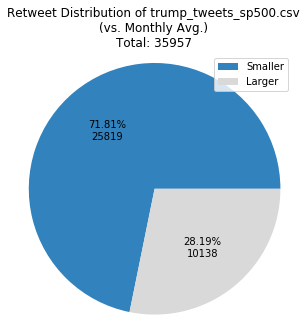

In [9]:
fig, ax = get_fig_ax(1, 1, 5, 5)
ax = visualize_class_distribution(stock_tweet[output_col], 
                                  given_title="Retweet Distribution of {}\n(vs. Monthly Avg.)".format(file_name), 
                                  given_label_titles={1: "Larger", 0:"Smaller"}, axes=ax, row_idx=0, col_idx=0)

## 1.1 Class Distribution since Election

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


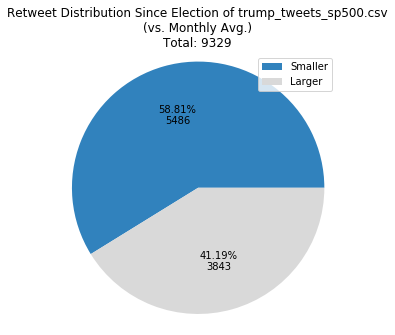

In [10]:
fig, ax = get_fig_ax(1, 1, 5, 5)
ax = visualize_class_distribution(since_election[output_col], 
                                  given_title="Retweet Distribution Since Election of {}\n(vs. Monthly Avg.)".format(file_name), 
                                  given_label_titles={1: "Larger", 0:"Smaller"}, axes=ax, row_idx=0, col_idx=0)

# 2.0 Most Common Words

In [11]:
def filtered_word_array(tweet, words_to_ignore={}):
    return [x for x in tweet.split(' ') if x not in stop_words.union(words_to_ignore) and re.search('[a-zA-Z]', x)]

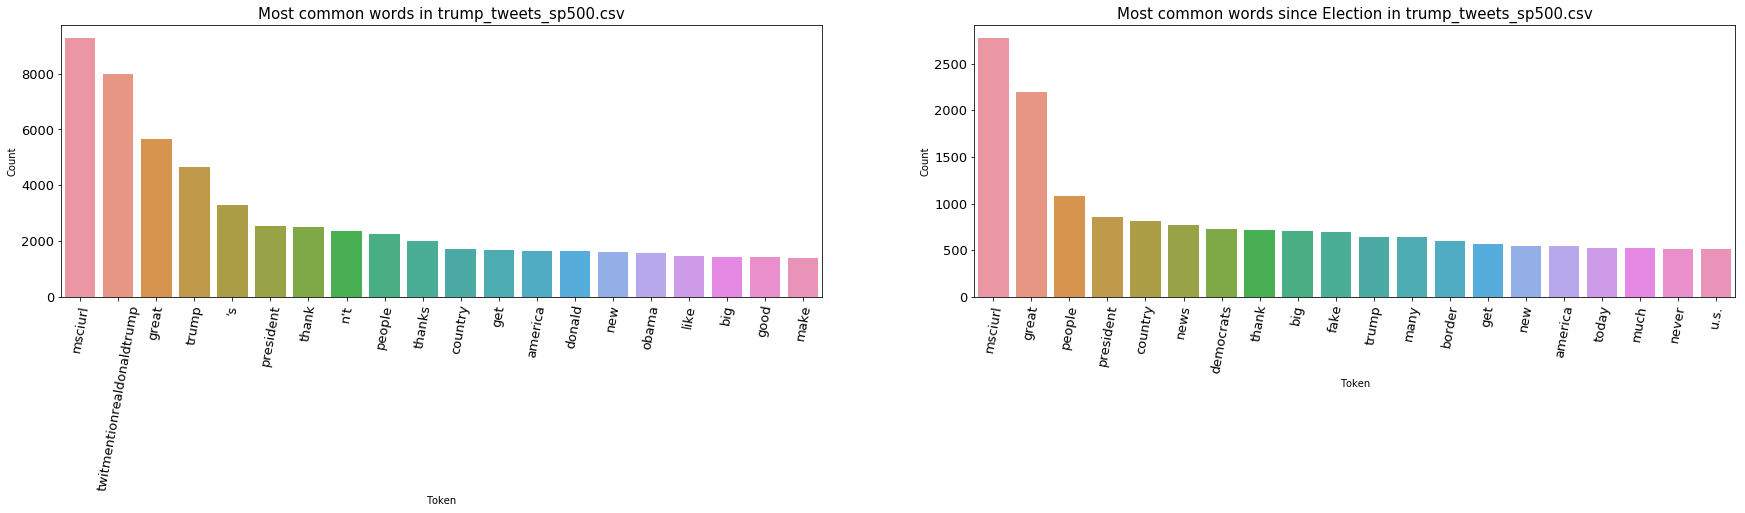

In [12]:
fig, ax = get_fig_ax(1, 2, 15, 5)
ax = top_n_tokens_plot_from_counter(Counter([x for x in filtered_word_array(' '.join(prep_all_tweets))]), 
                                    20, ax, 0, 0, "Most common words in {}".format(file_name))
ax = top_n_tokens_plot_from_counter(Counter([x for x in filtered_word_array(' '.join(prep_tweets_since_election))]), 
                                    20, ax, 0, 1, "Most common words since Election in {}".format(file_name))

## 2.1 Most Common Words (Larger vs Smaller than monthly average)

In [13]:
above_avg = stock_tweet[stock_tweet[output_col] == 1]
above_avg_since_election = since_election[since_election[output_col] == 1]
below_avg = stock_tweet[stock_tweet[output_col] == 0]
below_avg_since_election = since_election[since_election[output_col] == 0]

In [14]:
def get_count_no_sw(df):
    return Counter(filtered_word_array(' '.join(df['preprocessed_text'].tolist())))

In [15]:
above_not_below = get_count_no_sw(above_avg) - get_count_no_sw(below_avg)
above_not_below_since_election = get_count_no_sw(above_avg_since_election) - get_count_no_sw(below_avg_since_election)
below_not_above = get_count_no_sw(below_avg) - get_count_no_sw(above_avg)
below_not_above_since_election = get_count_no_sw(below_avg_since_election) - get_count_no_sw(above_avg_since_election)

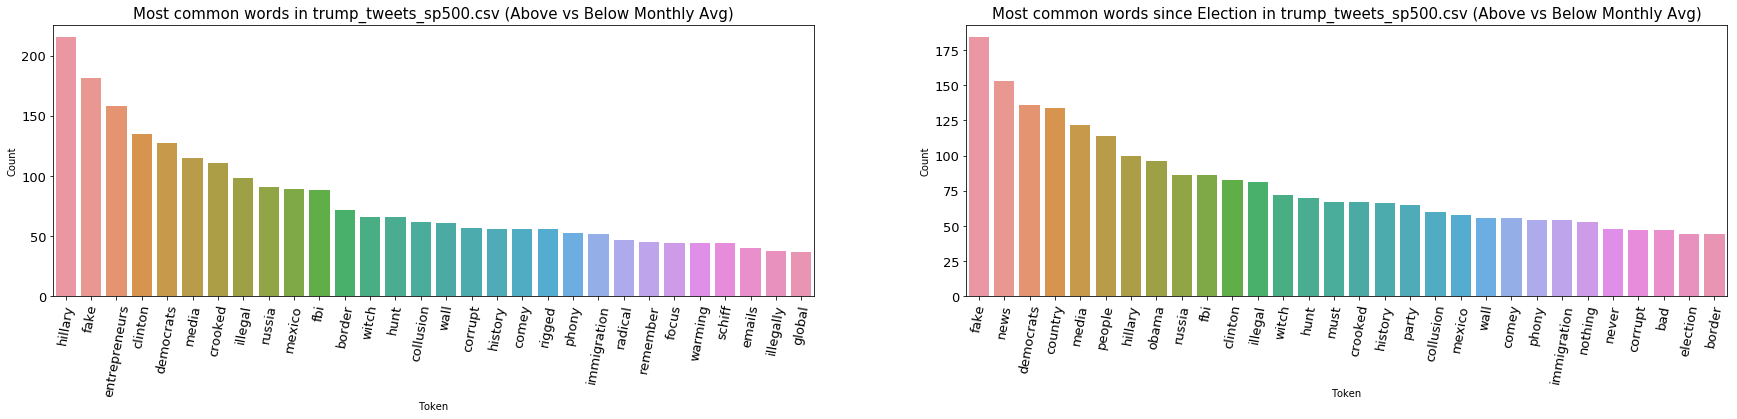

In [16]:
fig, ax = get_fig_ax(1, 2, 15, 5)
ax = top_n_tokens_plot_from_counter(above_not_below, 30, ax, 0, 0, 
                                    "Most common words in {} (Above vs Below Monthly Avg)".format(file_name))
ax = top_n_tokens_plot_from_counter(above_not_below_since_election, 30, ax, 0, 1, 
                                    "Most common words since Election in {} (Above vs Below Monthly Avg)".format(file_name))

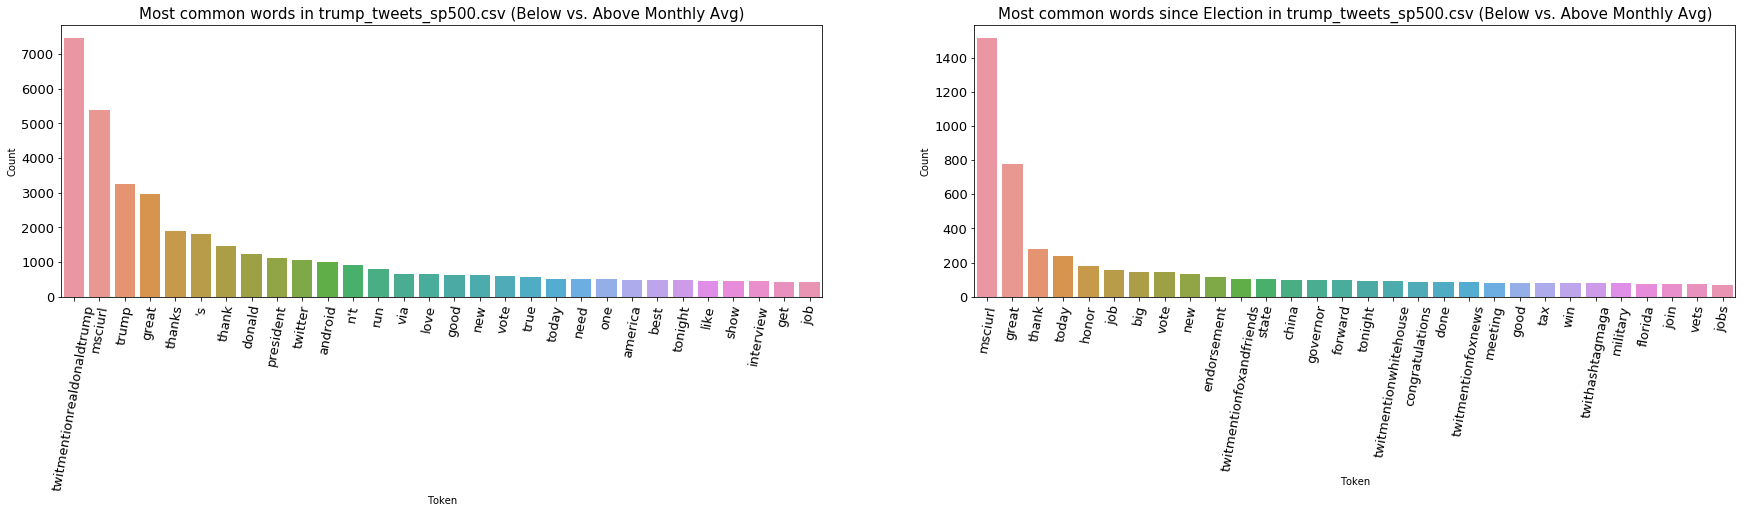

In [17]:
fig, ax = get_fig_ax(1, 2, 15, 5)
ax = top_n_tokens_plot_from_counter(below_not_above, 30, ax, 0, 0, 
                                    "Most common words in {} (Below vs. Above Monthly Avg)".format(file_name))
ax = top_n_tokens_plot_from_counter(below_not_above_since_election, 30, ax, 0, 1, 
                                    "Most common words since Election in {} (Below vs. Above Monthly Avg)".format(file_name))

# K-Means Clustering for Common Topics

Summarize this but don't need to say much else

Ran out of memory trying to do this for all Trump tweets - I'm only going to do it for tweets since the election.  
Elbow method: https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

# 3.0 Apriori - Featuresets
- Due to the small number of tweets, etc, we need to use a relatively low support of 0.02 before starting to look for rules

In [18]:
def prep_fn(text):
    text = text.split(" ")
    final = []
    for word in text:
        if re.search('[a-zA-Z]', word) and word not in stop_words:
            final.append(word)
    return final

In [19]:
frequent_itemsets = apriori_with_df(prep_tweets_since_election, prep_fn, min_support=0.02, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.020045,(administration)
1,0.028406,(also)
2,0.054132,(america)
3,0.038161,(american)
4,0.040197,(back)
5,0.035052,(bad)
6,0.020259,(best)
7,0.024118,(better)
8,0.071069,(big)
9,0.053168,(border)


## Using these frequent itemsets, we can come up with association rules:

In [20]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(honor),(msciurl),0.024333,0.272484,0.021331,0.876652,3.217264,0.014701,5.898079
1,(news),(fake),0.076428,0.068710,0.059170,0.774194,11.267475,0.053919,4.124282
2,(fake),(news),0.068710,0.076428,0.059170,0.861154,11.267475,0.053919,6.651791
3,"(media, news)",(fake),0.025726,0.068710,0.024011,0.933333,13.583567,0.022243,13.969343
4,"(media, fake)",(news),0.027334,0.076428,0.024011,0.878431,11.493529,0.021922,7.597122
5,(witch),(hunt),0.029264,0.029264,0.028942,0.989011,33.796643,0.028086,88.337014
6,(hunt),(witch),0.029264,0.029264,0.028942,0.989011,33.796643,0.028086,88.337014
7,(united),(states),0.045450,0.043413,0.037839,0.832547,19.177364,0.035866,5.712576
8,(states),(united),0.043413,0.045450,0.037839,0.871605,19.177364,0.035866,7.434479


## We can use these itemsets as inputs to our SVM

# WILL NEED TO MOVE THIS INTO THE CROSS VALIDATION PIPELINE!!!

In [21]:
above_avg_apr = apriori_with_df(since_election[since_election[output_col] == 1]['preprocessed_text'].tolist(), prep_fn).values.tolist()
above_avg_apr_dict = {x[1]: x[0] for x in above_avg_apr if len(x[1]) > 1}
above_avg_apr_set = set([x[1] for x in above_avg_apr])

In [22]:
below_avg_apr = apriori_with_df(since_election[since_election[output_col] == 0]['preprocessed_text'], prep_fn).values.tolist()
below_avg_apr_dict = {x[1]: x[0] for x in below_avg_apr if len(x[1]) > 1}
below_avg_apr_set = set([x[1] for x in below_avg_apr])

In [23]:
below_avg_apr_dict

{frozenset({'big', 'great'}): 0.02150929639081298,
 frozenset({'msciurl', 'today'}): 0.037732409770324465,
 frozenset({'msciurl', 'thank'}): 0.05614290922347794,
 frozenset({'great', 'thank'}): 0.027706890266131972,
 frozenset({'america', 'great'}): 0.024243528982865477,
 frozenset({'great', 'honor'}): 0.023332118118847976,
 frozenset({'great', 'honor', 'msciurl'}): 0.02132701421800948,
 frozenset({'america', 'msciurl'}): 0.025519504192489974,
 frozenset({'states', 'united'}): 0.028982865475756472,
 frozenset({'fake', 'news'}): 0.037550127597520966,
 frozenset({'great', 'state'}): 0.024790375501275976,
 frozenset({'great', 'msciurl'}): 0.07874589865111192,
 frozenset({'great', 'people'}): 0.027342325920524973,
 frozenset({'honor', 'msciurl'}): 0.03335763762304047,
 frozenset({'great', 'job'}): 0.02825373678454247,
 frozenset({'house', 'white'}): 0.02023332118118848,
 frozenset({'president', 'trump'}): 0.02005103900838498,
 frozenset({'great', 'today'}): 0.026248632883703972}

In [24]:
above_avg_apr_diff = Counter(above_avg_apr_dict) - Counter(below_avg_apr_dict)

In [25]:
below_avg_apr_diff = Counter(below_avg_apr_dict) - Counter(above_avg_apr_dict)

In [26]:
below_avg_apr_diff.items()

dict_items([(frozenset({'big', 'great'}), 0.02150929639081298), (frozenset({'today', 'msciurl'}), 0.037732409770324465), (frozenset({'thank', 'msciurl'}), 0.03168285197653545), (frozenset({'thank', 'great'}), 0.027706890266131972), (frozenset({'honor', 'great'}), 0.023332118118847976), (frozenset({'msciurl', 'honor', 'great'}), 0.02132701421800948), (frozenset({'msciurl', 'america'}), 0.025519504192489974), (frozenset({'state', 'great'}), 0.024790375501275976), (frozenset({'msciurl', 'great'}), 0.055586908279006794), (frozenset({'msciurl', 'honor'}), 0.03335763762304047), (frozenset({'job', 'great'}), 0.02825373678454247), (frozenset({'house', 'white'}), 0.02023332118118848), (frozenset({'trump', 'president'}), 0.02005103900838498), (frozenset({'today', 'great'}), 0.026248632883703972)])

In [27]:
above_avg_apr_feats = sorted([x for x in above_avg_apr_diff.most_common(4) if x[1] > 0.04], key=lambda x: x[1], reverse=True)
below_avg_apr_feats = sorted([x for x in below_avg_apr_diff.most_common(4) if x[1] > 0.04], key=lambda x: x[1], reverse=True)

In [28]:
above_avg_apr_feats

[(frozenset({'fake', 'news'}), 0.052483700141224804),
 (frozenset({'fake', 'media'}), 0.04553734061930783),
 (frozenset({'hunt', 'witch'}), 0.04449648711943794),
 (frozenset({'media', 'news'}), 0.04267499349466563)]

In [29]:
# feat = above_avg_apr_feats[0]

In [30]:
def contains_feature(tweets, feat):
    contains_feat_list = []
    for tweet in tweets:
        curr_set = [1 if word in set(tweet) else 0 for word in feat]
#         print(feat, curr_set)
#         print(ting)
        contains_feat_list.append(min(curr_set))
    return contains_feat_list

In [31]:
tweets = list(map(lambda x: x.split(" "), prep_tweets_since_election))

In [32]:
for feat in above_avg_apr_feats:
    col_name = "above_avg_apr_{}".format('_'.join(feat[0]))
    since_election[col_name] = contains_feature(tweets, feat[0])
    since_election[col_name] = since_election[col_name].astype('category')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [33]:
for feat in below_avg_apr_feats:
    col_name = "below_avg_apr_{}".format('_'.join(feat[0]))
    since_election[col_name] = contains_feature(tweets, feat[0])
    since_election[col_name] = since_election[col_name].astype('category')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [34]:
since_election.columns

Index(['text', 'created_at', 'retweet_count', 'favorite_count', 'is_retweet',
       'after_dir', '1_open_dir', '1_close_dir', '2_open_dir', '2_close_dir',
       'eow_close_dir', 'sow_open_dir', 'sig_up', 'sig_down', 'is_sig',
       'preprocessed_text', 'created_hour', 'dow', 'num_links', 'num_words',
       'above_monthly_avg', 'percent_caps', 'num_hashtags', 'num_mentions',
       'above_avg_apr_news_fake', 'above_avg_apr_media_fake',
       'above_avg_apr_witch_hunt', 'above_avg_apr_news_media',
       'below_avg_apr_msciurl_great'],
      dtype='object')

## 3.3 LDA for Topic Clustering - SKIPPING FOR NOW, SINCE IT'S NOT TECHNICALLY PART OF THE REPORT

This section focuses on using Latent Dirichlet Allocation (LDA) to learn yet more about the hidden structure within the top 100 film synopses. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. There is quite a good high-level overview of probabilistic topic models by one of the big names in the field, David Blei, available in the Communications of the ACM here. Incidentally, Blei was one of the authors of the seminal paper on LDA.
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

HAD TO ADD THE WORD "GREAT" TO THE STOPWORD LIST BECAUSE IT WAS IN LITERALLY EVERY CLUSTER...

In [71]:
# Remove proper nouns (in this case get rid of all mentions)
since_election['preprocessed_no_mentions'] = since_election['preprocessed_text'].apply(lambda tweet: ' '.join([w for w in tweet.split(' ') 
                                                                                                               if w not in stop_words.union({'msciurl', 'great'}) 
                                                                                                               and re.search('[a-zA-Z]', w)]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [83]:
texts = [[ting for ting in x.split(" ") if ting != ''] for x in since_election['preprocessed_no_mentions'].tolist()]
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.3)
# 0.21

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [84]:
coherence_scores = []
for i in range(2, 50, 2):
    lda = models.LdaMulticore(corpus, num_topics=i, 
                                id2word=dictionary, iterations=500)
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

In [85]:
# coherence_scores

Text(0.5, 0, 'Num Topics')

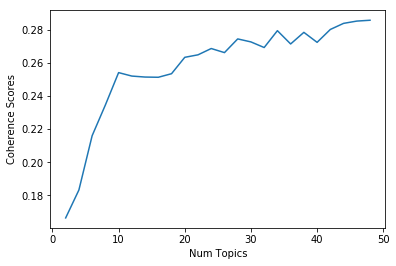

In [86]:
plt.plot([x for x in range(2, 50, 2)], coherence_scores)
plt.ylabel("Coherence Scores")
plt.xlabel("Num Topics")

In [87]:
lda_num_topics = 12

In [88]:
lda = models.LdaMulticore(corpus, num_topics=lda_num_topics, iterations=500,
                                id2word=dictionary)

In [89]:
lda.show_topics(num_topics=lda_num_topics)

[(0,
  '0.009*"news" + 0.008*"fake" + 0.006*"border" + 0.006*"want" + 0.005*"democrats" + 0.005*"trump" + 0.004*"new" + 0.004*"media" + 0.004*"must" + 0.004*"collusion"'),
 (1,
  '0.011*"fake" + 0.011*"news" + 0.009*"people" + 0.008*"president" + 0.008*"trump" + 0.007*"many" + 0.007*"u.s." + 0.007*"media" + 0.006*"country" + 0.005*"get"'),
 (2,
  '0.009*"people" + 0.008*"border" + 0.008*"big" + 0.007*"country" + 0.007*"president" + 0.006*"democrats" + 0.006*"get" + 0.006*"new" + 0.005*"must" + 0.005*"many"'),
 (3,
  '0.008*"people" + 0.008*"china" + 0.007*"states" + 0.006*"united" + 0.005*"new" + 0.005*"tariffs" + 0.005*"president" + 0.005*"today" + 0.005*"deal" + 0.004*"want"'),
 (4,
  '0.006*"democrats" + 0.006*"president" + 0.005*"many" + 0.005*"even" + 0.005*"way" + 0.005*"republicans" + 0.005*"trump" + 0.004*"today" + 0.004*"america" + 0.004*"vote"'),
 (5,
  '0.007*"people" + 0.006*"trump" + 0.005*"look" + 0.005*"new" + 0.004*"u.s." + 0.004*"president" + 0.004*"make" + 0.003*"way"

- The area of circle represents the importance of each topic over the entire corpus
- The distance between the center of circles indicate the similarity between topics.
- Indices = sorted order by area
- Blue = overall term frequency
- Red = term freq within selected topic
- Lambda: trying to strike a balance between choosing general vs specific words (lambda=0 means super specific - exclusively popular for this topic)
- If some topics contain general words/feelings/sentiments

In [90]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [91]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# df_dominant_topic.head(10)
df_dominant_topic['preprocessed_text'] = prep_tweets_since_election

In [92]:
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda.show_topics(num_topics=lda_num_topics, formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

# print(lda.show_topics(num_topics=lda_num_topics, formatted=False))

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(' '.join)
df_top3words.reset_index(level=0,inplace=True)
df_top3words

,topic_id,words
0,0,news fake border
1,1,fake news people
2,2,people border big
3,3,people china states
4,4,democrats president many
5,5,people trump look
6,6,president big thank
7,7,country people democrats
8,8,back big president
9,9,people news fake


In [93]:
df = None
sample_size=5
for i in range(lda_num_topics):
    curr_cluster = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == i].sort_values(by='Topic_Perc_Contrib', ascending=False)
    if df is None:
        df = curr_cluster.head(sample_size)#.sample(n=min(sample_size, len(curr_cluster.index)-1))
    else:
        df = df.append(curr_cluster.head(sample_size))#curr_cluster.sample(n=min(sample_size, len(curr_cluster.index)-1)))
    df = df.append(pd.Series(), ignore_index=True)
df[["preprocessed_text", "Dominant_Topic", 'Topic_Perc_Contrib']]

,preprocessed_text,Dominant_Topic,Topic_Perc_Contrib
0,"the fake news washington post amazon ' s "" chief lobbyist "" has another ( of many ) phony headlines "" trump defiant as china adds trade penalties. "" wrong ! should read "" trump defiant as u.s . adds trade penalties will end barriers and massive i.p . theft. "" typically bad reporting !",0.0,0.9730
1,the rigged witch hunt originally headed by fbi lover boy peter s ( for one year ) & now 13 angry democrats should look into the missing dnc server crooked hillary ' s illegally deleted emails the pakistani fraudster uranium one podesta & so much more . it ' s a democrat con job !,0.0,0.9713
2,ex-fbi layer lisa page today defied a house of representatives issued subpoena to testify before congress ! wow but is anybody really surprised ! together with her lover fbi agent peter strzok she worked on the rigged witch hunt perhaps the most tainted and corrupt case ever !,0.0,0.9713
3,cnn & others within the fake news universe were going wild about my signing maga hats for our military in iraq and germany . if these brave young people ask me to sign their hat i will sign . can you imagine my saying no ? we brought or gave no hats as the fake news first reported !,0.0,0.9704
4,airplanes are becoming far too complex to fly . pilots are no longer needed but rather computer scientists from mit . i see it all the time in many products . always seeking to go one unnecessary step further when often old and simpler is far better . split second decisions are ... .,0.0,0.9704
5,NaN,NaN,NaN
6,so many people at the higher ends of intelligence loved my press conference performance in helsinki . putin and i discussed many important subjects at our earlier meeting . we got along well which truly bothered many haters who wanted to see a boxing match . big results will come !,1.0,0.9713
7,the fake news gets crazier and more dishonest every single day . amazing to watch as certain people covering me and the tremendous success of this administration have truly gone mad ! their fake reporting creates anger and disunity . take two weeks off and come back rested . chill !,1.0,0.9713
8,democrat uaw local 1112 president david green ought to get his act together and produce . g.m . let our country down but other much better car companies are coming into the u.s. in droves . i want action on lordstown fast . stop complaining and get the job done ! 3.8 % unemployment !,1.0,0.9713
9,.twitmentiondaveweigel twitmentionwashingtonpost put out a phony photo of an empty arena hours before i arrived @ the venue w/ thousands of people outside on their way in . real photos now shown as i spoke . packed house many people unable to get in . demand apology & retraction from fake news wapo ! msciurl,1.0,0.9713


# SAVE DATA (COMMENTED OUT)

In [47]:
# lda.save('44_clusters_removed_great_lda.model')
# df.to_csv('lda_44_clusters_removed_great.csv', index=False)

# LDA VISUALIZATION (COMMENTED OUT)

In [48]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
vis

# 4.0 Distributions

## 4.1.1 Time of Day (Up vs Down)

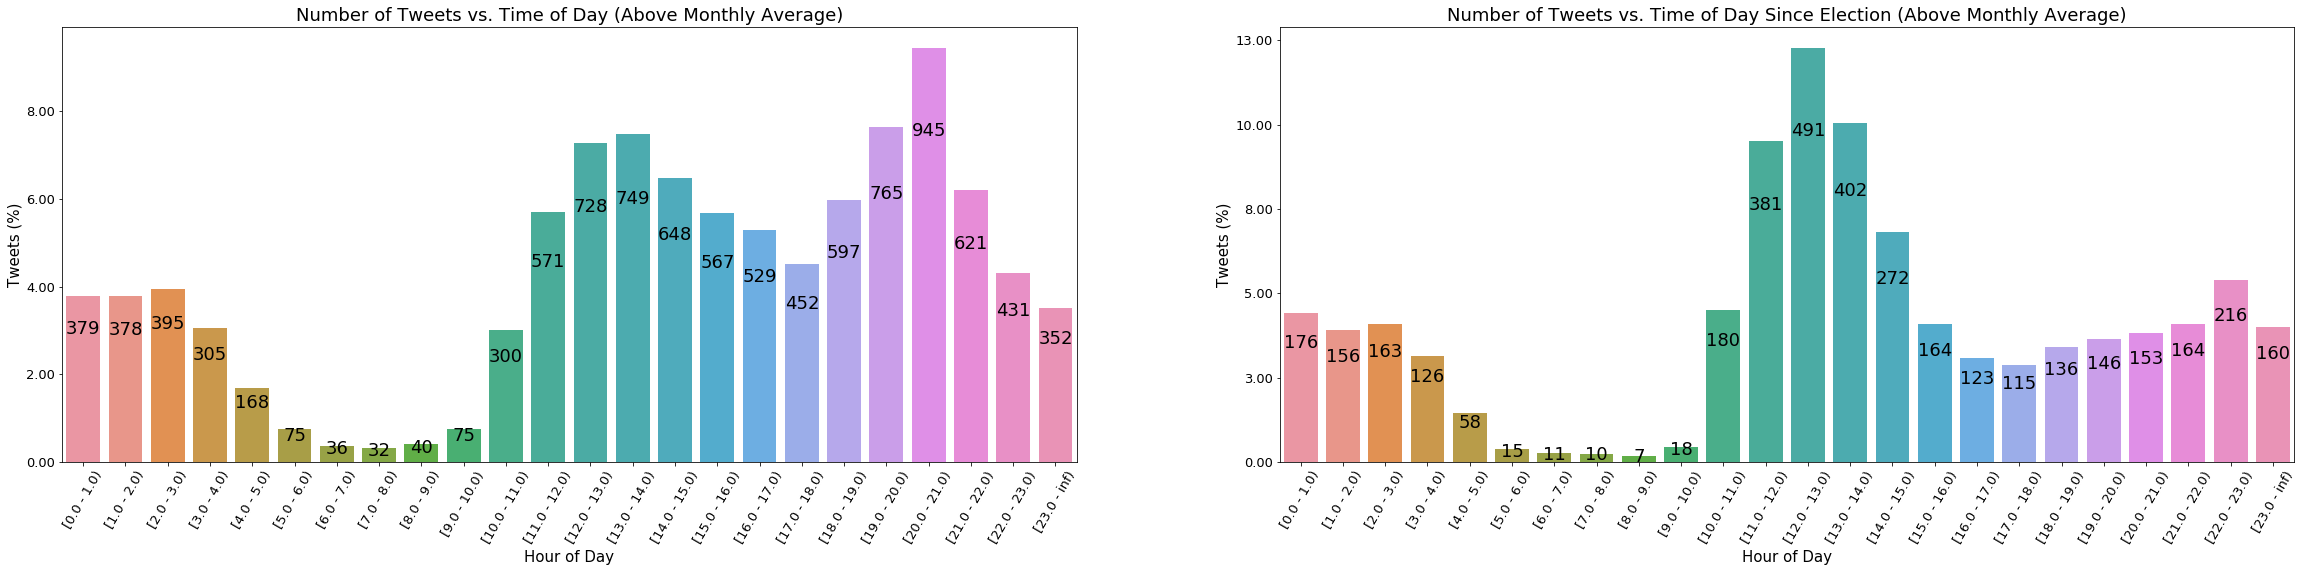

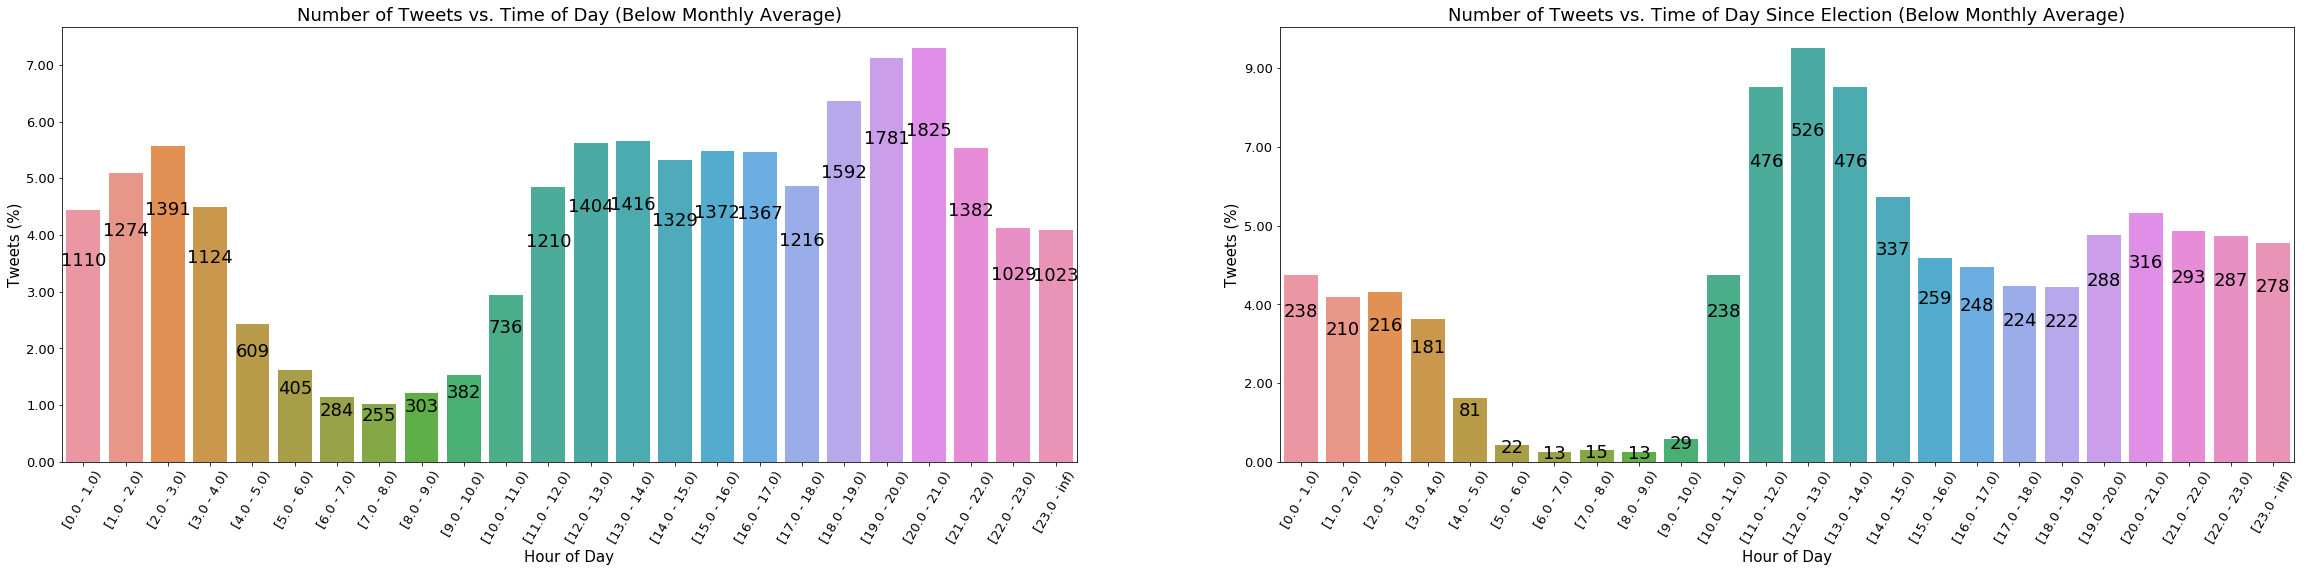

In [49]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["created_hour"], ax, 0, 0, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day (Above Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["created_hour"], ax, 0, 1, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day Since Election (Above Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["created_hour"], ax, 0, 0, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day (Below Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["created_hour"], ax, 0, 1, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day Since Election (Below Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)

## 4.2.1 Day of Week (Up vs Down)

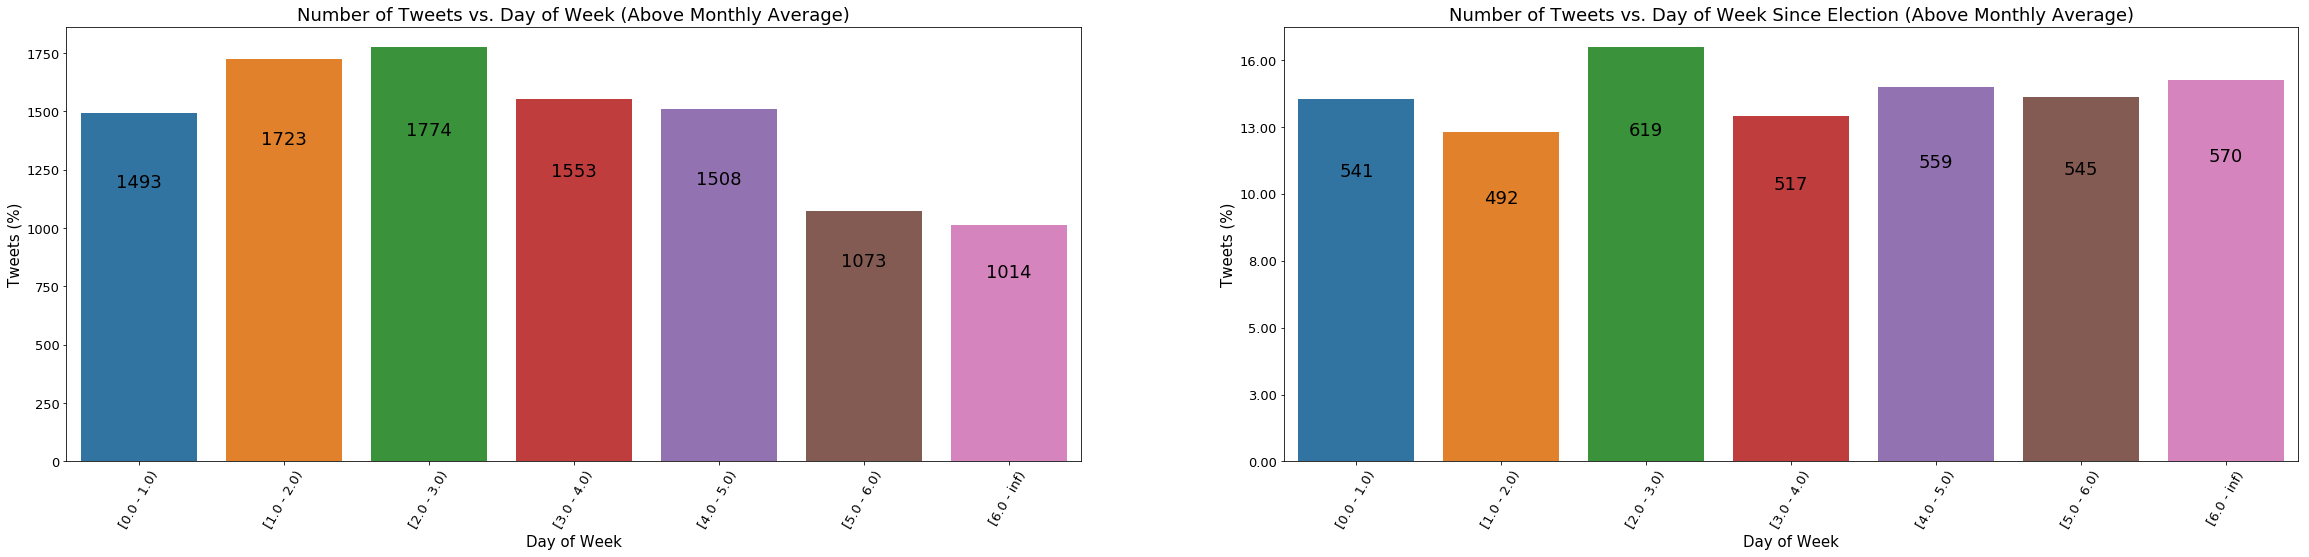

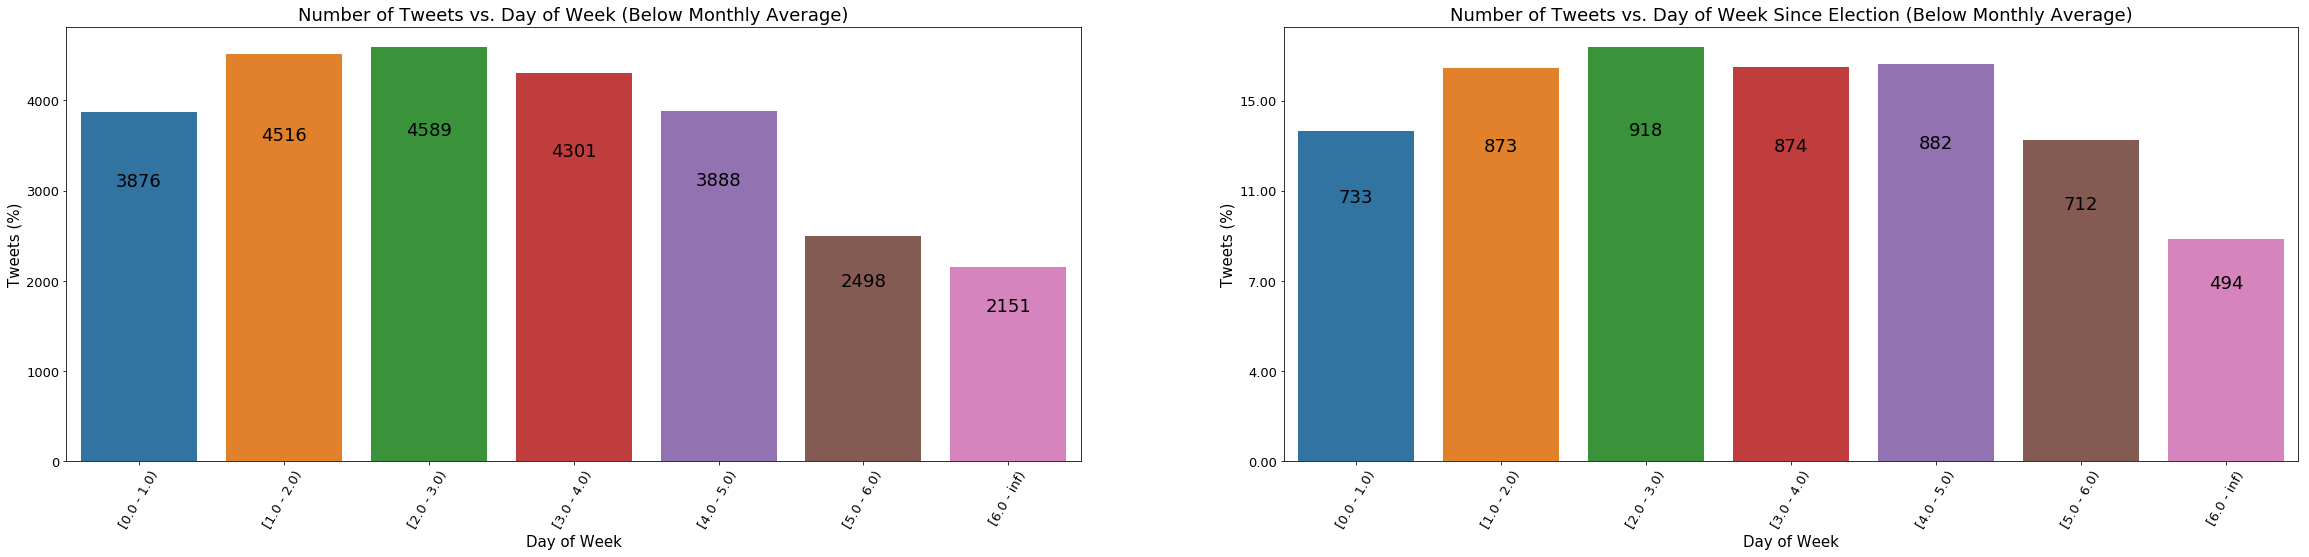

In [50]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["dow"], ax, 0, 0, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week (Above Monthly Average)", False, show_mean=False, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["dow"], ax, 0, 1, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week Since Election (Above Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["dow"], ax, 0, 0, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week (Below Monthly Average)", False, show_mean=False, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["dow"], ax, 0, 1, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week Since Election (Below Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)

## 4.3 Num Retweets over Time

In [51]:
from data_science_toolkit.file_ops import read_pkl
dt_avg = read_pkl("dt_avg_{}.pkl".format(file_name))

In [52]:
avg_retweets, dates = [], []
for year in dt_avg:
    for month in dt_avg[year]:
        avg_retweets.append(dt_avg[year][month])
        dates.append(datetime(year, month, 1))
dates, avg_retweets = list(zip(*sorted(list(zip(dates, avg_retweets)), key=lambda x: x[0])))

# Average Number of Retweets per Month
- The average number of retweets Trump gets per month varies significantly, and also jumped during the middle of the year (around when he got elected)
- This makes comparing to a monthly average more appropriate

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


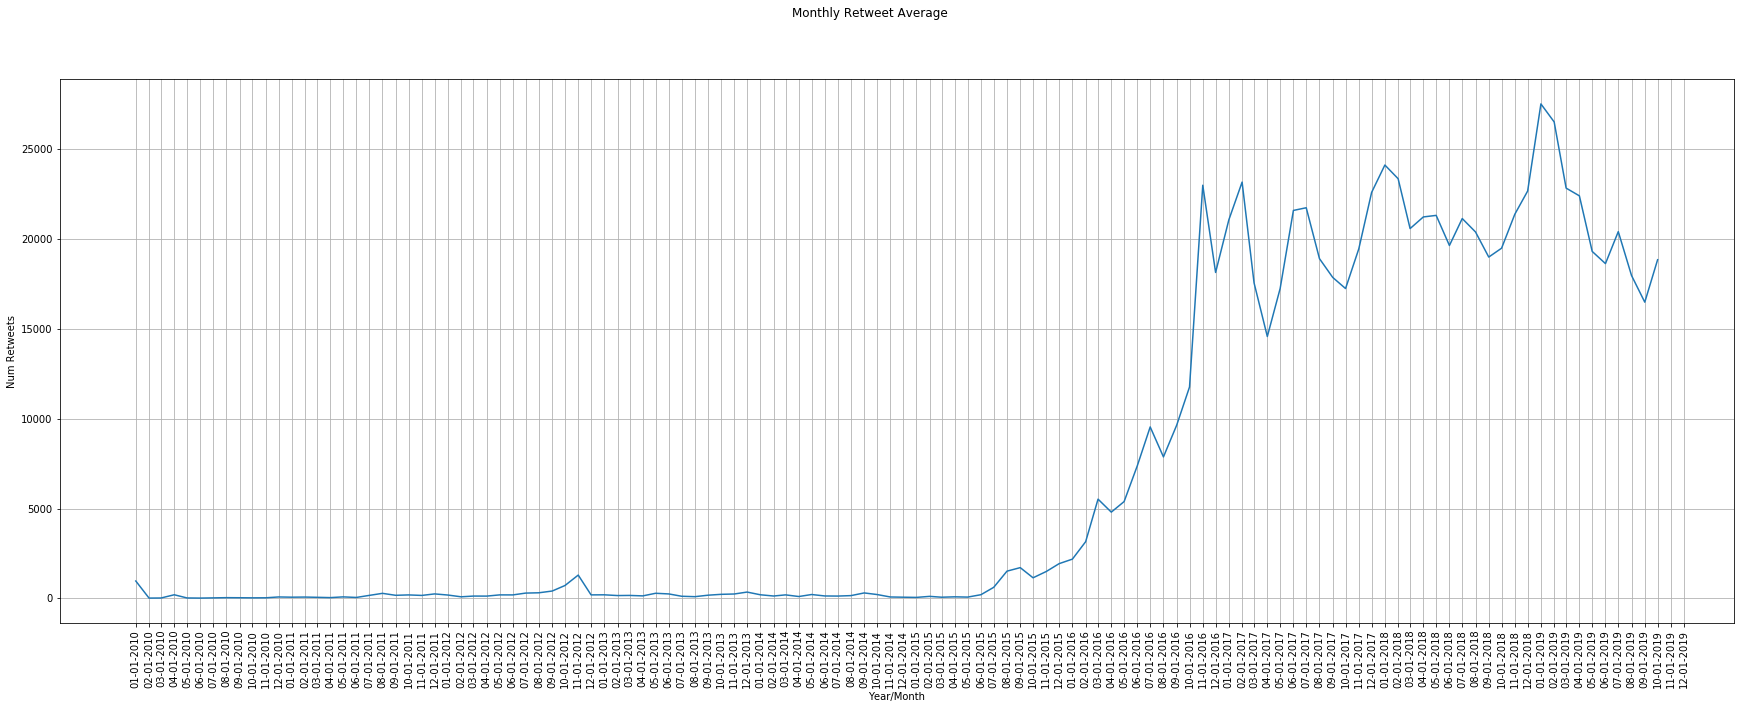

In [53]:
fig = plt.figure(figsize=(30, 10))
plt.plot(dates, avg_retweets)
fig.suptitle('Monthly Retweet Average')
plt.xlabel('Year/Month')
plt.ylabel('Num Retweets')
plt.xticks(dates, [x.strftime('%m-%d-%Y') for x in dates], rotation=90)
plt.grid(True)
plt.show()

## 5.1 Tweet Anatomy

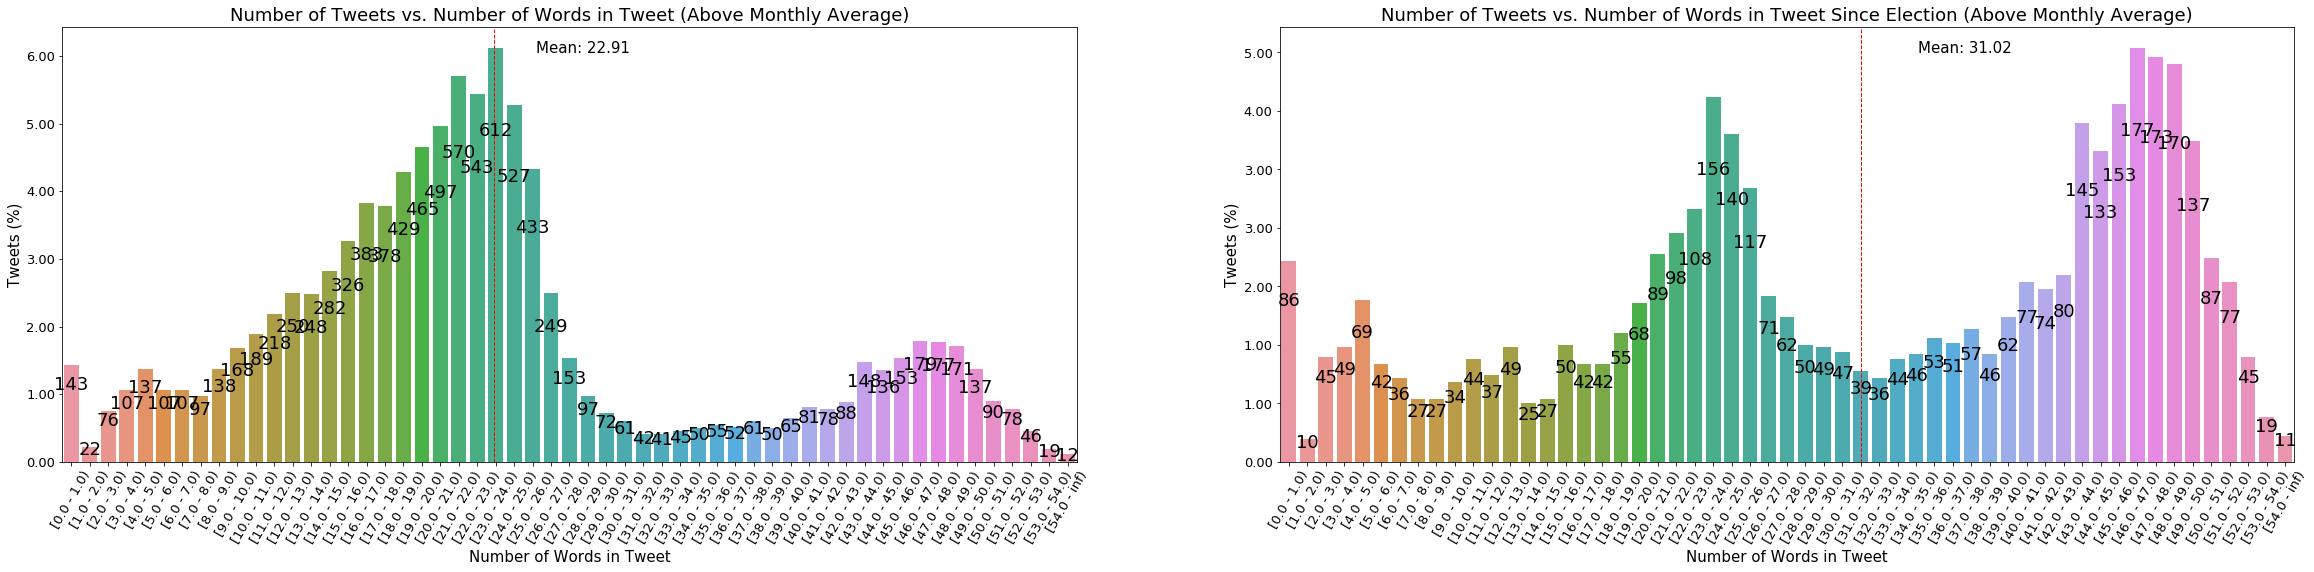

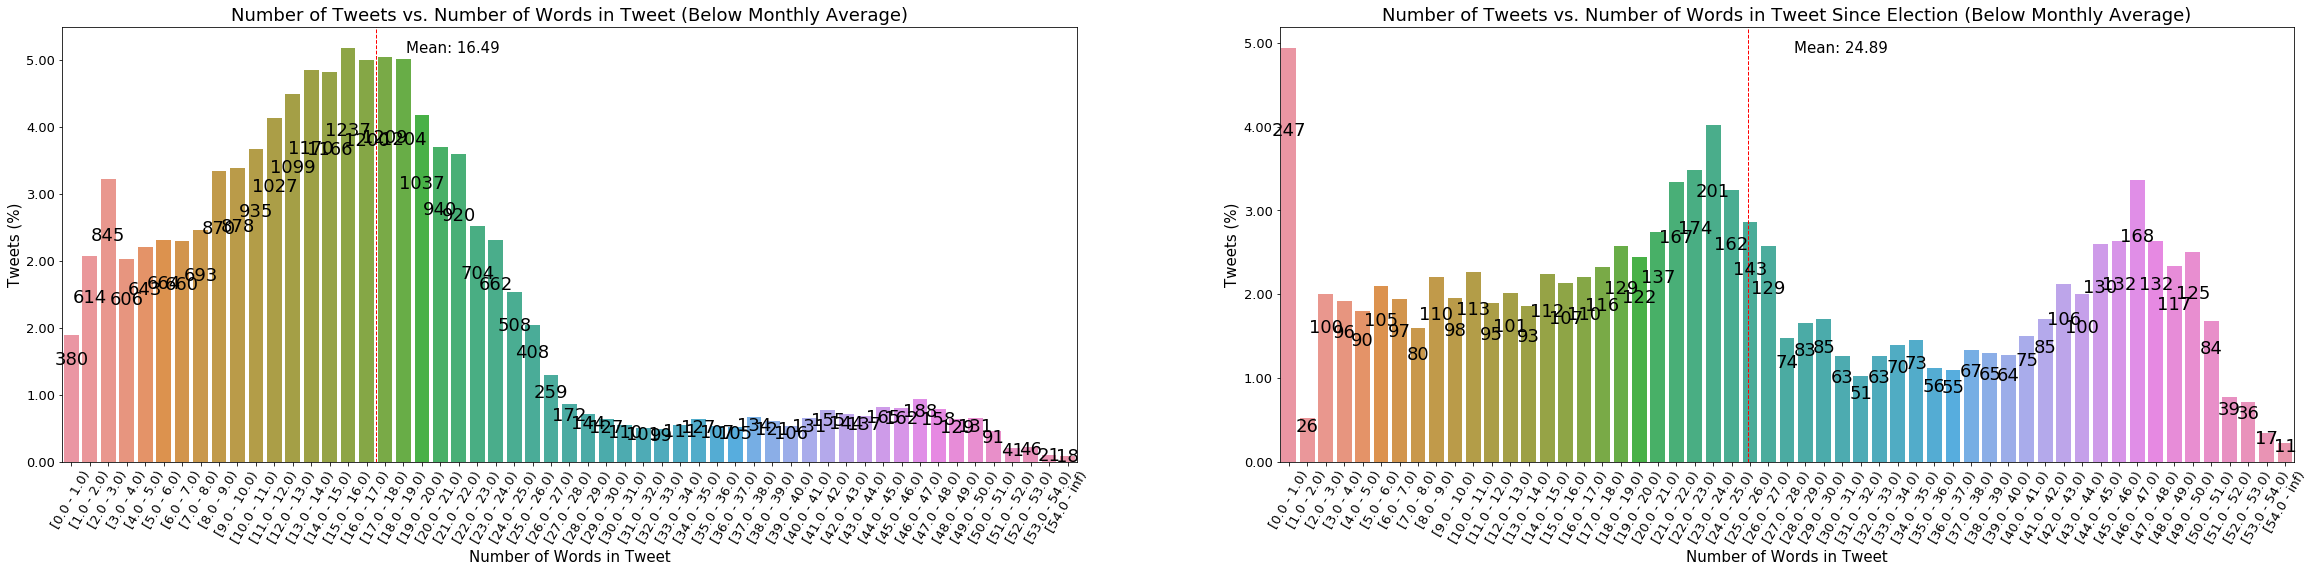

In [54]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_words"], ax, 0, 0, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_words"], ax, 0, 1, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_words"], ax, 0, 0, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_words"], ax, 0, 1, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [55]:
# since_election[since_election.num_words > 55]

In [56]:
set(stock_tweet[stock_tweet[output_col] == 0]['num_links'].tolist())

{0, 1}

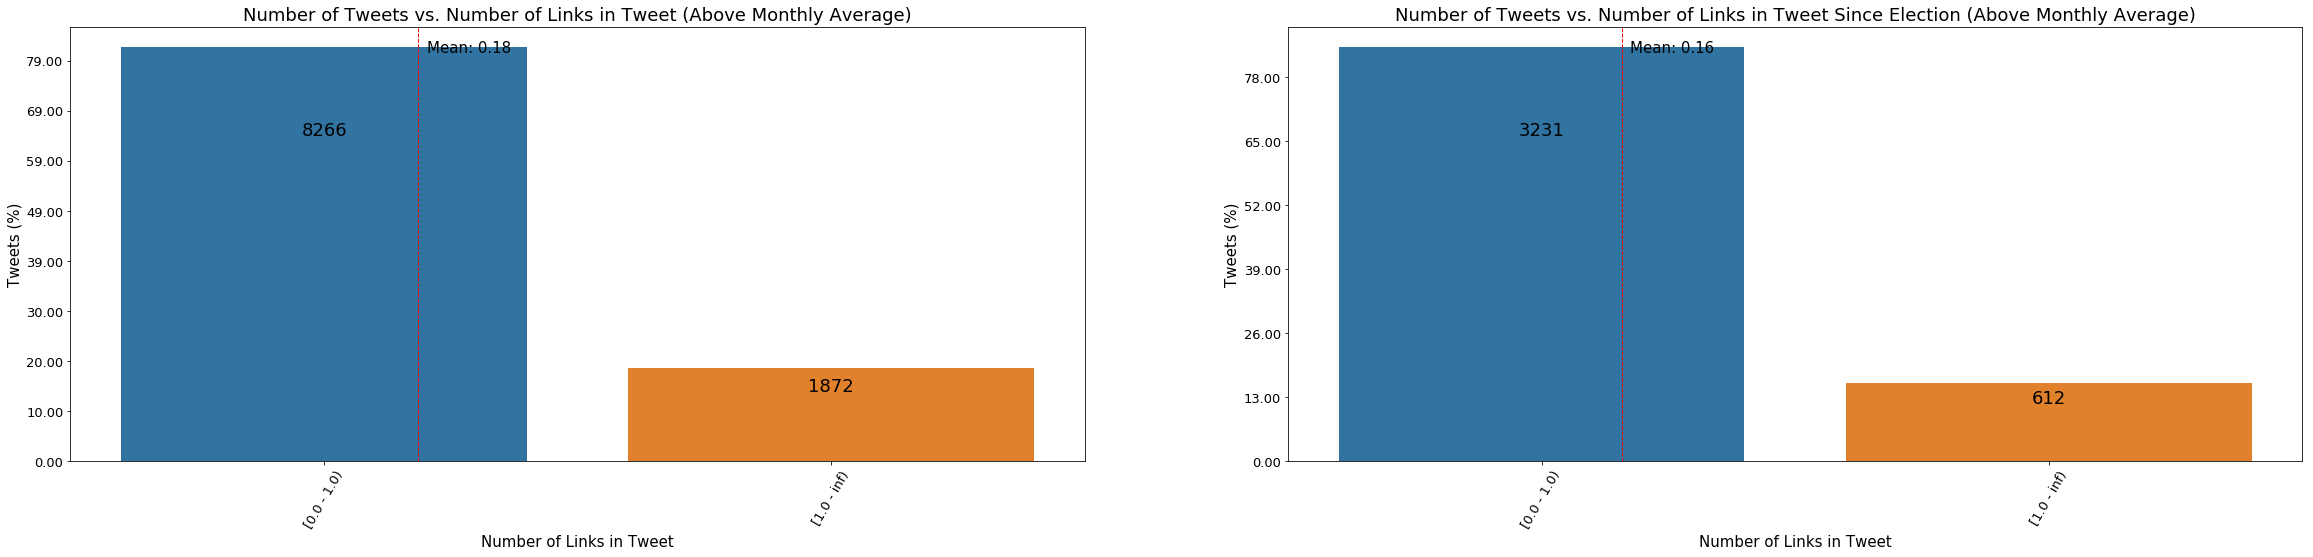

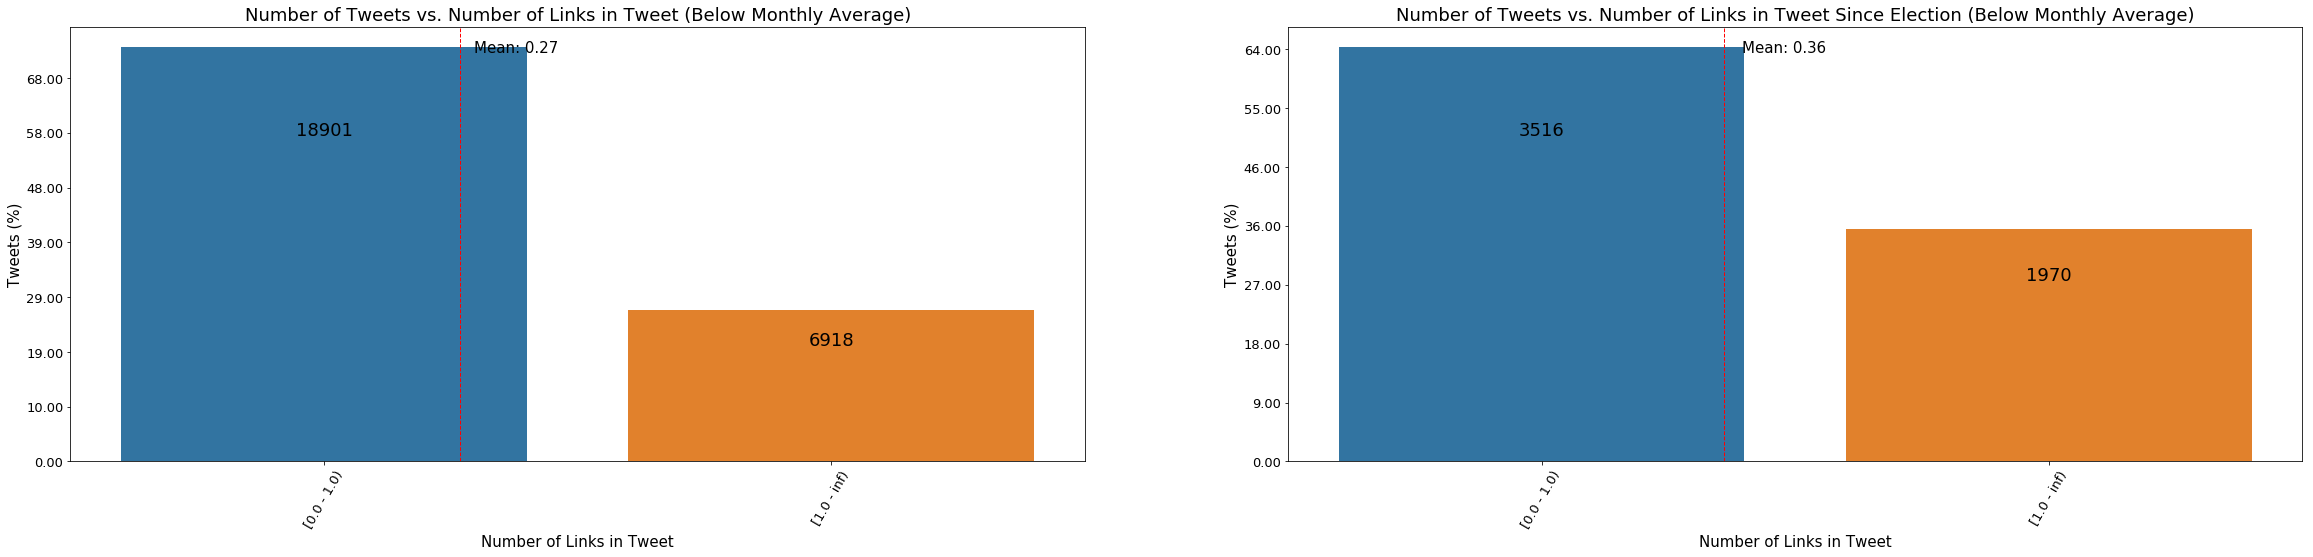

In [57]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_links"], ax, 0, 0, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_links"], ax, 0, 1, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_links"], ax, 0, 0, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_links"], ax, 0, 1, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

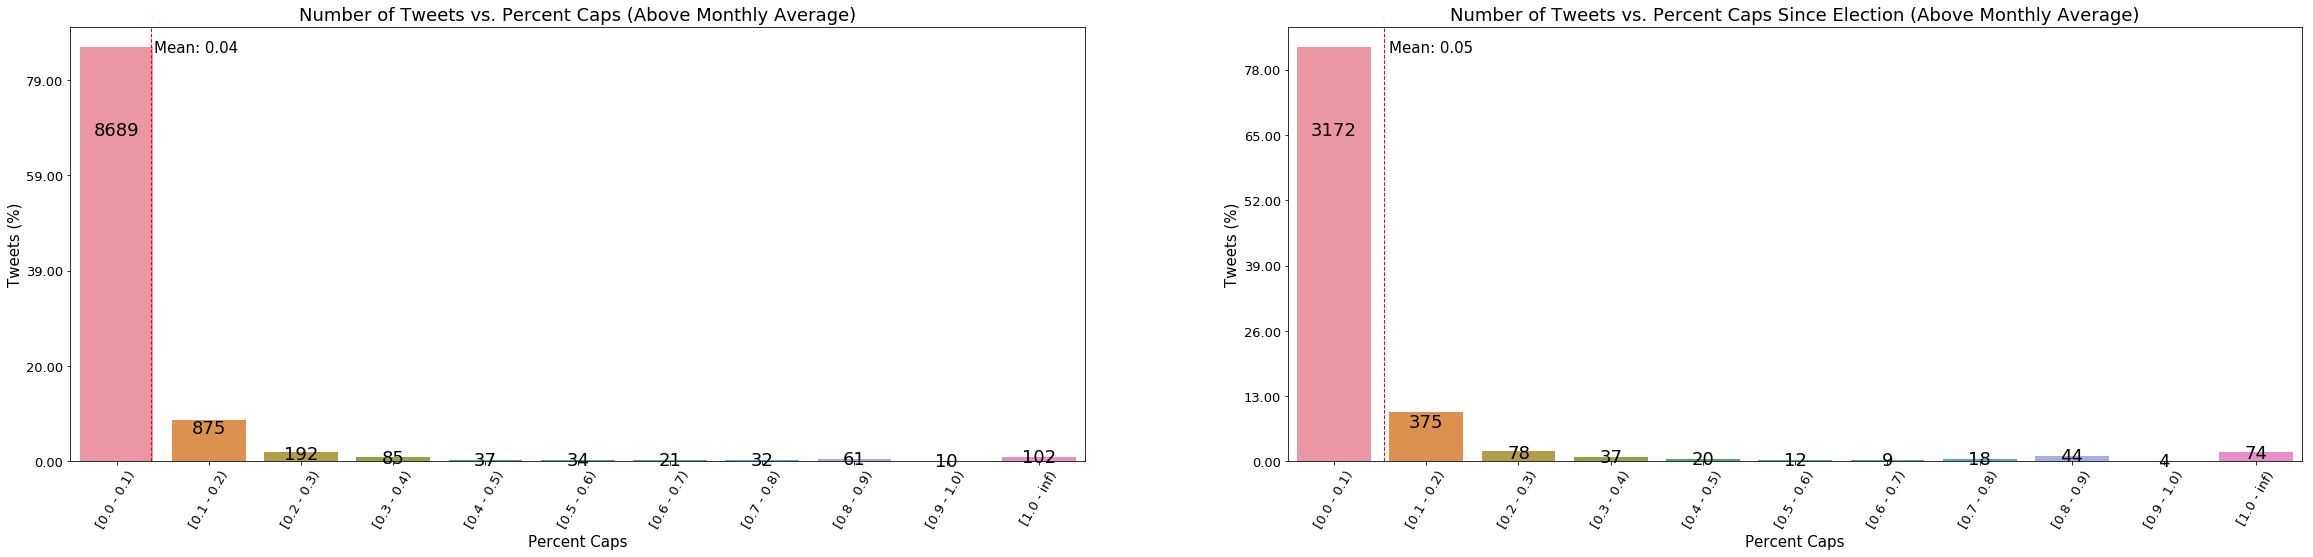

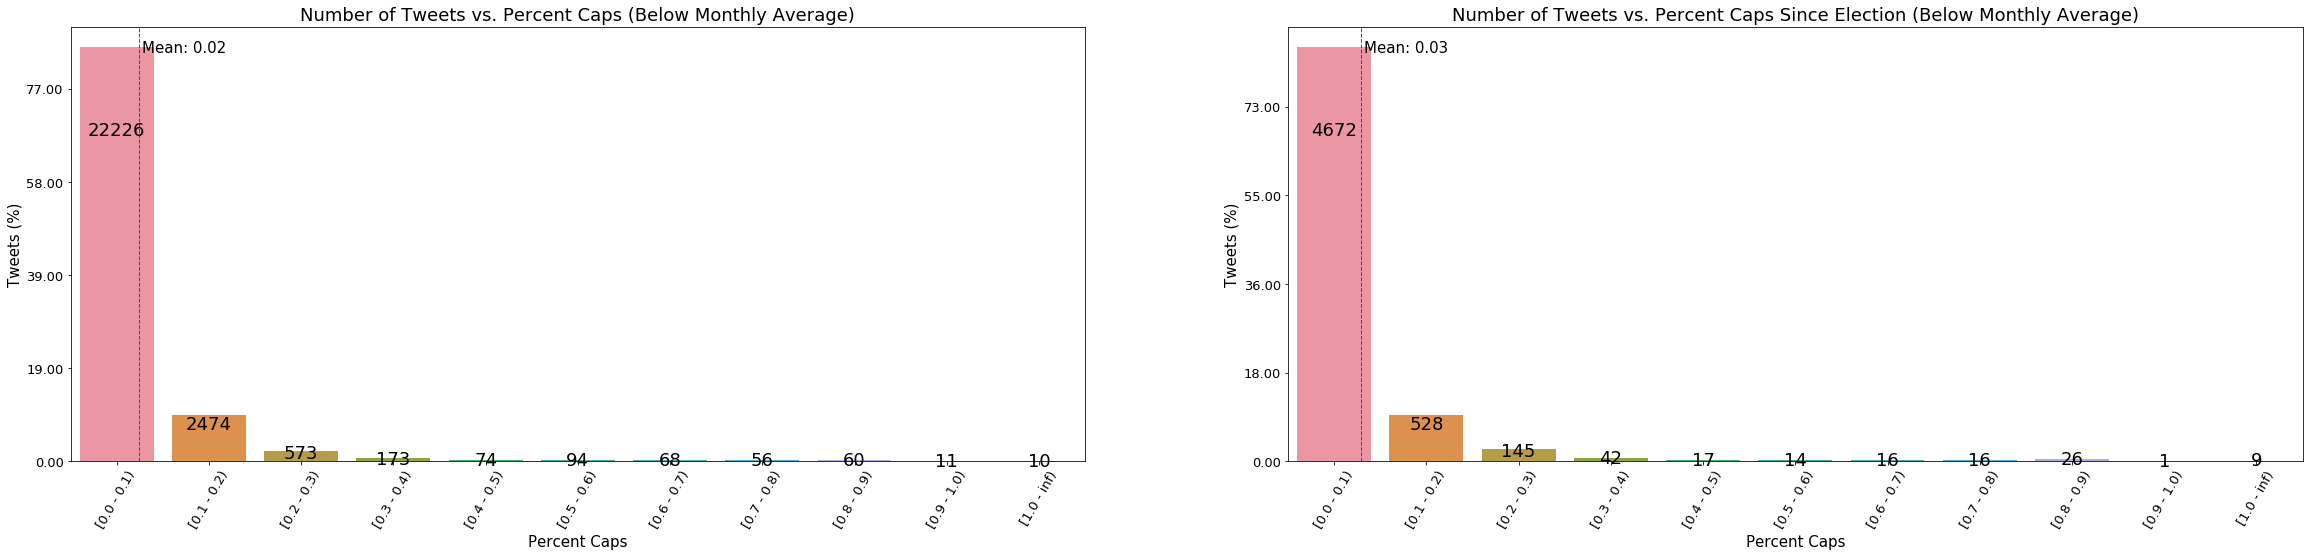

In [58]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["percent_caps"], ax, 0, 0, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["percent_caps"], ax, 0, 1, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["percent_caps"], ax, 0, 0, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["percent_caps"], ax, 0, 1, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

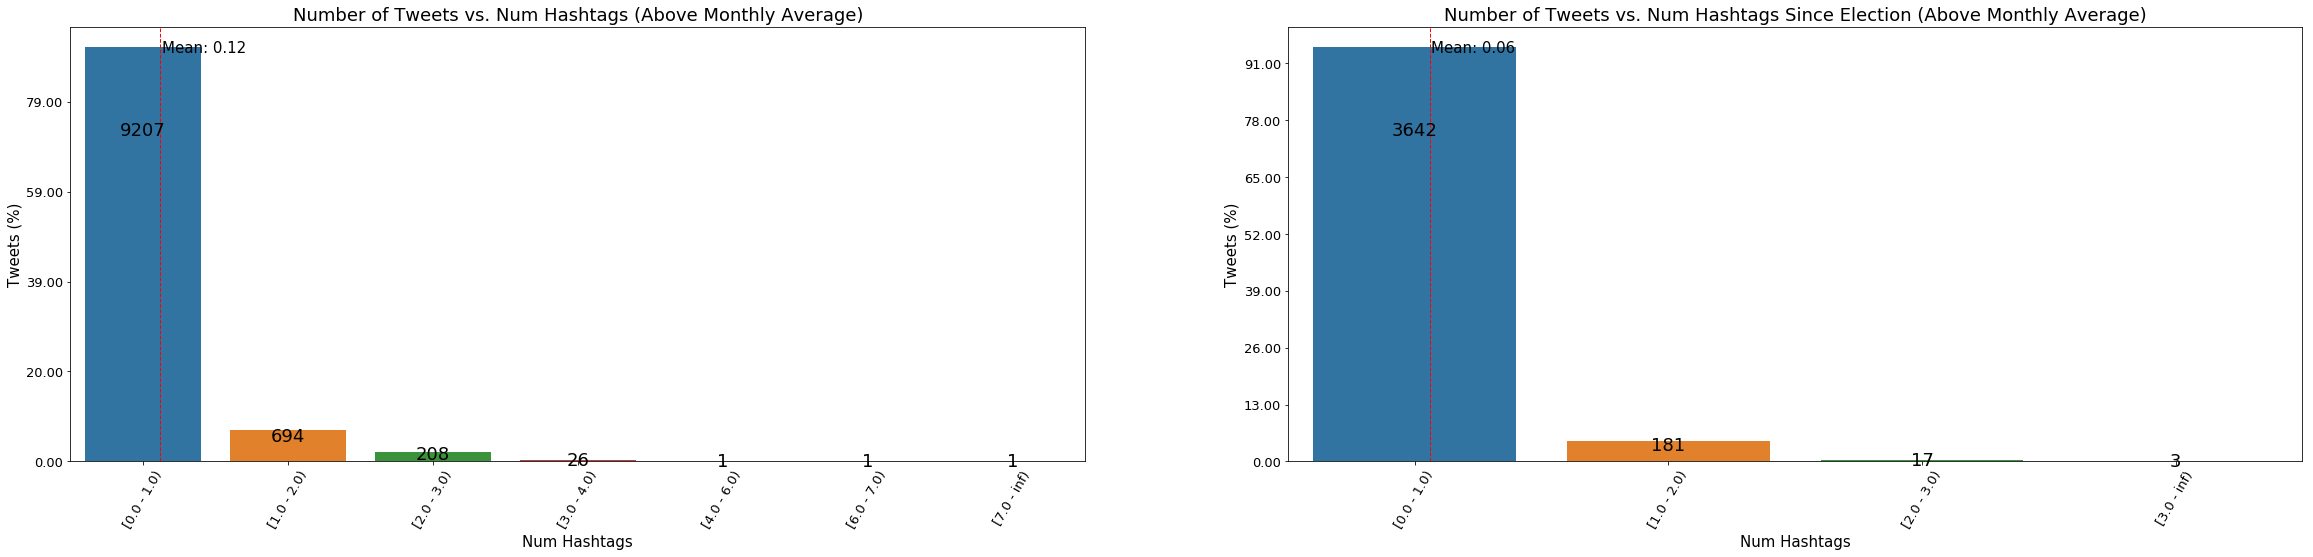

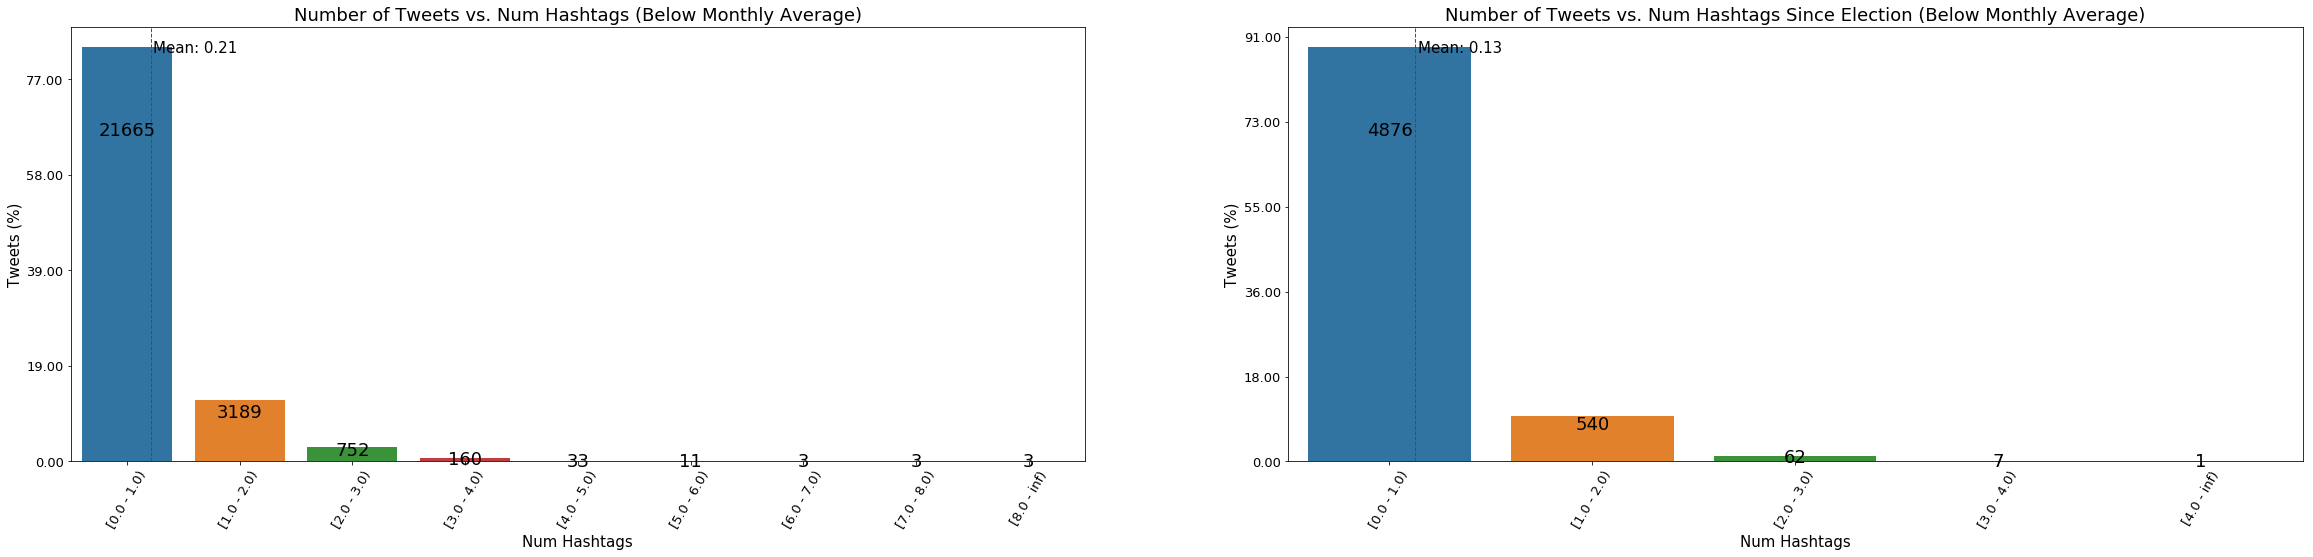

In [59]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_hashtags"], ax, 0, 0, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_hashtags"], ax, 0, 1, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_hashtags"], ax, 0, 0, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_hashtags"], ax, 0, 1, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

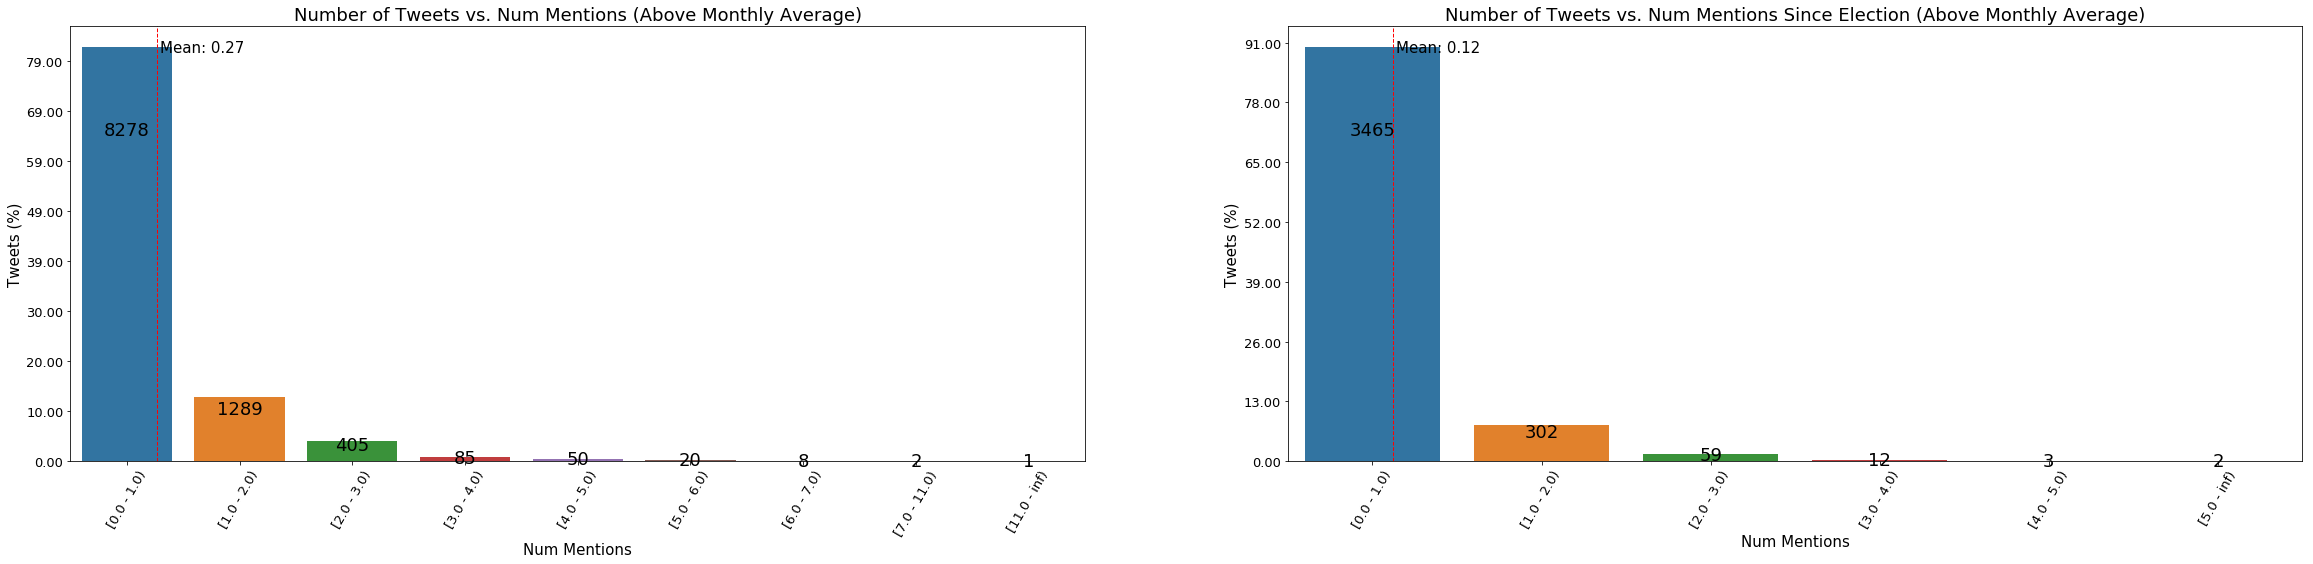

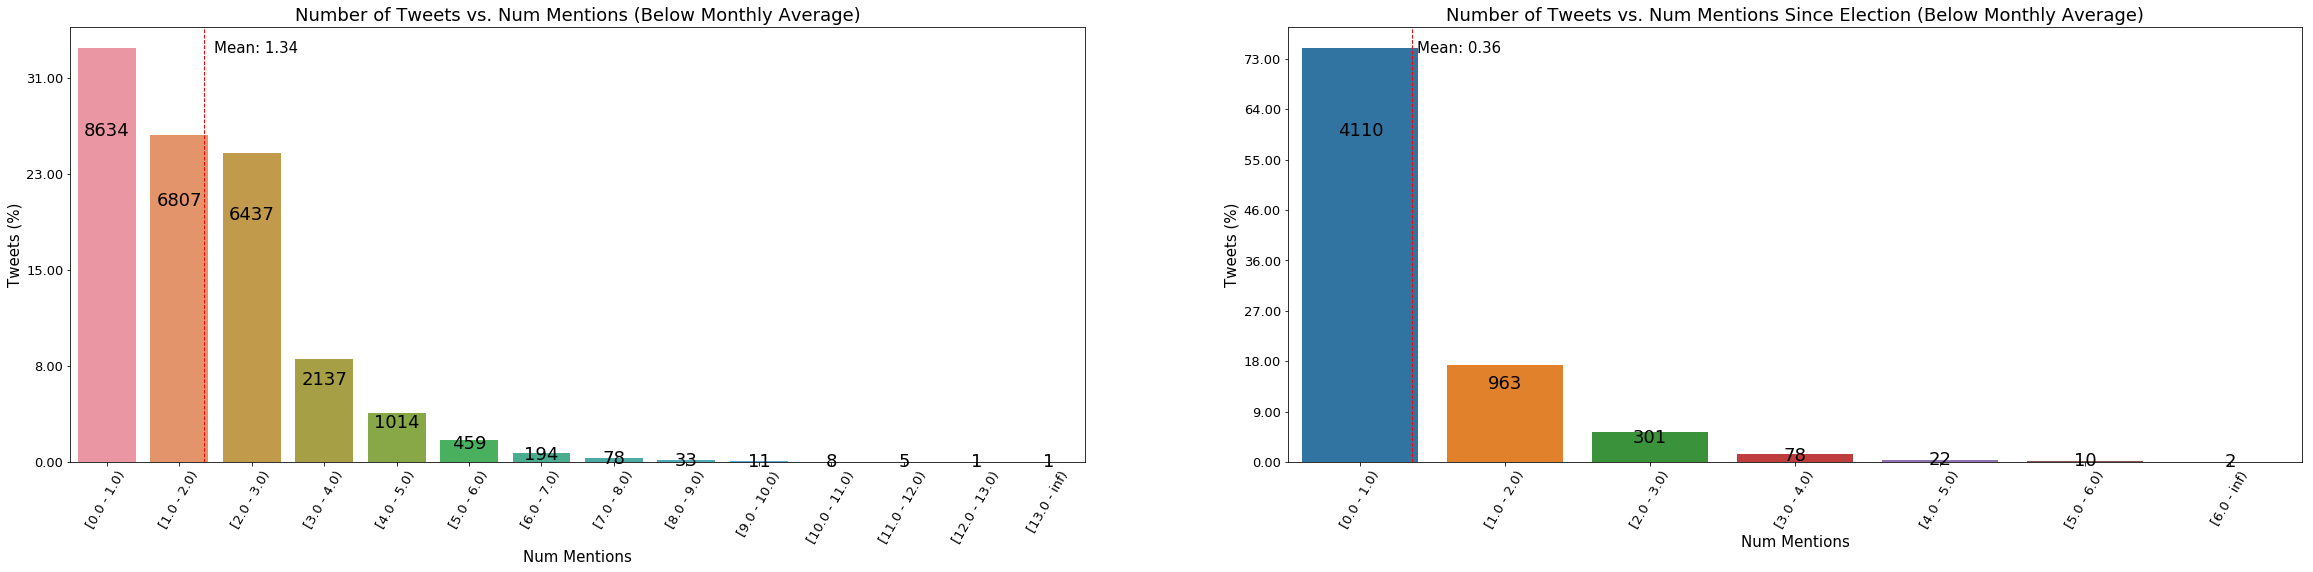

In [60]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_mentions"], ax, 0, 0, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_mentions"], ax, 0, 1, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_mentions"], ax, 0, 0, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_mentions"], ax, 0, 1, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [61]:
# stock_tweet.head(10)

In [62]:
# since_election.head(10)

## This is what we will be using for models...

In [63]:
since_election.to_csv('./since_election_with_cluster_{}'.format(file_name), index=False)